In [51]:

####################################################################################################
####################################################################################################

import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

sys.path.append(os.path.abspath("../python_pax_reader"))
import waveformset as wfset

from helpers import *

plt.style.use('dbarge')


In [52]:

####################################################################################################
####################################################################################################

file_raw   = "../data_xenon_waveform/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
file_truth = "../data_xenon_waveform/FakeWaveform_truth.csv"

nEvent = 1


In [27]:

####################################################################################################
####################################################################################################

nEventsGeant = 1000
wfs          = wfset.WaveformSet()
wfs.read_data_and_truth(file_raw, file_truth, nEventsGeant)



100%|██████████| 1000/1000 [00:03<00:00, 260.58it/s]

S2 not found!
S2 not found!
S2 not found!

Events:    993
PMT Shape: (248,)


In [40]:

####################################################################################################
####################################################################################################

df_pmts = wfs.get_waveforms_in_channels(nEvent).iloc[:, 0:127]



(350000, 127)

In [89]:

####################################################################################################
# Get Truth
####################################################################################################

df_truths   = wfs.truth()
df_truth    = df_truths[nEvent]
df_sum      = wfs.summed_waveforms(nEvent)
df_truth_s1 = df_truth.loc[df_truth['peak_type'] == 's1']
df_truth_s2 = df_truth.loc[df_truth['peak_type'] == 's2']
z_true      = np.round(df_truth_s1.iloc[0]['z'], 1)



In [91]:

####################################################################################################
# Get True S1, S2 Times
####################################################################################################

t0_s1 = np.round(df_truth_s1.iloc[0]['t_first_photon']   , 1)
t1_s1 = np.round(df_truth_s1.iloc[0]['t_last_photon']    , 1)
t0_s2 = np.round(df_truth_s2.iloc[0]['t_first_electron'] , 1)
t1_s2 = np.round(df_truth_s2.iloc[0]['t_last_electron']  , 1)

samp0_s1 = int(np.round(t0_s1 / 10))
samp1_s1 = int(np.round(t1_s1 / 10))
samp0_s2 = int(np.round(t0_s2 / 10))
samp1_s2 = int(np.round(t1_s2 / 10))

eps_s1 = (samp1_s1 - samp0_s1)*2.0
eps_s2 = (samp1_s2 - samp0_s2)*2.0

x0_s1  = samp0_s1 - eps_s1
x1_s1  = samp1_s1 + eps_s1
x0_s2  = samp0_s2 - eps_s2
x1_s2  = samp1_s2 + eps_s2

vdrift_mm_per_us = 1.44;
vdrift_cm_per_ns = vdrift_mm_per_us*(1/10)*(1/1000)

dt0 = np.round(t0_s2 - t0_s1)
dt1 = np.round(t1_s2 - t1_s1)

dz0 = -1*np.round(vdrift_cm_per_ns*dt0, 1)
dz1 = -1*np.round(vdrift_cm_per_ns*dt1, 1)


print()
print("S1 t_first_photon:   " + str(t0_s1)  + " ns")
print("S2 t_first_electron: " + str(t0_s2)  + " ns")
print("dt first:            " + str(dt0)    + " ns")
print("dz first:            " + str(dz0)    + " cm")
print("z true:              " + str(z_true) + " cm")
print()



S1 t_first_photon:   655031.1 ns
S2 t_first_electron: 1053706.3 ns
dt first:            398675.0 ns
dz first:            -57.4 cm
z true:              -57.5 cm



In [223]:

####################################################################################################
# Calculate PMT Ranking by S2 Integral
####################################################################################################

df_pmts_s2ranked         = waveformIndexRankedByIntegral(df_pmts, samp0_s2, samp1_s2)
nSamples                 = len(df_pmts.index)
     
idxs_pmts_top127         = df_pmts_s2ranked.iloc[0:127, 0:1].as_matrix().reshape(127)
idxs_pmts_top065         = df_pmts_s2ranked.iloc[0: 65, 0:1].as_matrix().reshape(65)
idxs_pmts_top050         = df_pmts_s2ranked.iloc[0: 50, 0:1].as_matrix().reshape(50)
idxs_pmts_top030         = df_pmts_s2ranked.iloc[0: 30, 0:1].as_matrix().reshape(30)
idxs_pmts_top020         = df_pmts_s2ranked.iloc[0: 20, 0:1].as_matrix().reshape(20)
idxs_pmts_top010         = df_pmts_s2ranked.iloc[0: 10, 0:1].as_matrix().reshape(10)
idxs_pmts_top001         = df_pmts_s2ranked.iloc[0:  1, 0:1].as_matrix().reshape(1)

arr_waveform_sum127      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top127, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum065      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top065, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum050      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top050, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum030      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top030, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum020      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top020, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum010      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top010, samp0_s2, samp1_s2).as_matrix()
arr_waveform_sum001      = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top001, samp0_s2, samp1_s2).as_matrix()

sum_s2_top127            = np.sum(arr_waveform_sum127[samp0_s2:samp1_s2])
sum_s2_top065            = np.sum(arr_waveform_sum065[samp0_s2:samp1_s2])
sum_s2_top050            = np.sum(arr_waveform_sum050[samp0_s2:samp1_s2])
sum_s2_top030            = np.sum(arr_waveform_sum030[samp0_s2:samp1_s2])
sum_s2_top020            = np.sum(arr_waveform_sum020[samp0_s2:samp1_s2])
sum_s2_top010            = np.sum(arr_waveform_sum010[samp0_s2:samp1_s2])
sum_s2_top001            = np.sum(arr_waveform_sum001[samp0_s2:samp1_s2])

arr_waveform_sum127_norm = np.divide(arr_waveform_sum127, sum_s2_top127*np.ones(nSamples)) 
arr_waveform_sum065_norm = np.divide(arr_waveform_sum065, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum050_norm = np.divide(arr_waveform_sum050, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum030_norm = np.divide(arr_waveform_sum030, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum020_norm = np.divide(arr_waveform_sum020, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum010_norm = np.divide(arr_waveform_sum010, sum_s2_top127*np.ones(nSamples))
arr_waveform_sum001_norm = np.divide(arr_waveform_sum001, sum_s2_top127*np.ones(nSamples))

frac_s2_top127           = np.round(100*(sum_s2_top127 / sum_s2_top127), 1)
frac_s2_top065           = np.round(100*(sum_s2_top065 / sum_s2_top127), 1)
frac_s2_top050           = np.round(100*(sum_s2_top050 / sum_s2_top127), 1)
frac_s2_top030           = np.round(100*(sum_s2_top030 / sum_s2_top127), 1)
frac_s2_top020           = np.round(100*(sum_s2_top020 / sum_s2_top127), 1)
frac_s2_top010           = np.round(100*(sum_s2_top010 / sum_s2_top127), 1)
frac_s2_top001           = np.round(100*(sum_s2_top001 / sum_s2_top127), 1)


####################################################################################################
####################################################################################################

arr_s2sum_ranked  = df_pmts_s2ranked.iloc[:, 1].as_matrix().reshape(len(df_pmts_s2ranked.index), 1)
arr_s2idx_ranked  = df_pmts_s2ranked.iloc[:, 0].as_matrix().reshape(len(df_pmts_s2ranked.index), 1)
arr_s2frac_ranked = arr_s2sum_ranked / sum_s2_top127
arr_s2idx_ranked  = arr_s2idx_ranked.astype(int)


####################################################################################################
####################################################################################################

idx_pmt_rank001 = arr_s2idx_ranked[  0, 0]
idx_pmt_rank002 = arr_s2idx_ranked[  1, 0]
idx_pmt_rank003 = arr_s2idx_ranked[  2, 0]
idx_pmt_rank004 = arr_s2idx_ranked[  3, 0]
idx_pmt_rank005 = arr_s2idx_ranked[  4, 0]
idx_pmt_rank006 = arr_s2idx_ranked[  5, 0]
idx_pmt_rank007 = arr_s2idx_ranked[  6, 0]
idx_pmt_rank008 = arr_s2idx_ranked[  7, 0]
idx_pmt_rank009 = arr_s2idx_ranked[  8, 0]
idx_pmt_rank010 = arr_s2idx_ranked[  9, 0]
idx_pmt_rank050 = arr_s2idx_ranked[ 49, 0]
idx_pmt_rank075 = arr_s2idx_ranked[ 75, 0]
idx_pmt_rank100 = arr_s2idx_ranked[100, 0]

arr_waveform_rank001 = df_pmts.iloc[:, idx_pmt_rank001]
arr_waveform_rank002 = df_pmts.iloc[:, idx_pmt_rank002]
arr_waveform_rank003 = df_pmts.iloc[:, idx_pmt_rank003]
arr_waveform_rank004 = df_pmts.iloc[:, idx_pmt_rank004]
arr_waveform_rank005 = df_pmts.iloc[:, idx_pmt_rank005]
arr_waveform_rank006 = df_pmts.iloc[:, idx_pmt_rank006]
arr_waveform_rank007 = df_pmts.iloc[:, idx_pmt_rank007]
arr_waveform_rank008 = df_pmts.iloc[:, idx_pmt_rank008]
arr_waveform_rank009 = df_pmts.iloc[:, idx_pmt_rank009]
arr_waveform_rank010 = df_pmts.iloc[:, idx_pmt_rank010]
arr_waveform_rank050 = df_pmts.iloc[:, idx_pmt_rank050]
arr_waveform_rank075 = df_pmts.iloc[:, idx_pmt_rank075]
arr_waveform_rank100 = df_pmts.iloc[:, idx_pmt_rank100]

if (frac_s2_top127 != 100):
    
    print("Error in Normalizatoin!")
    
    
####################################################################################################
####################################################################################################

print()
print("S2 Integral over 127 top PMTs:\t" + str(sum_s2_top127))
print("S2 Integral over   1 top PMTs:\t" + str(sum_s2_top001))
print("S2 Fraction, top PMTs:\t\t" + str(frac_s2_top001) + " %")
print()




S2 Integral over 127 top PMTs:	47331.0
S2 Integral over   1 top PMTs:	12024.0
S2 Fraction, top PMTs:		25.4 %



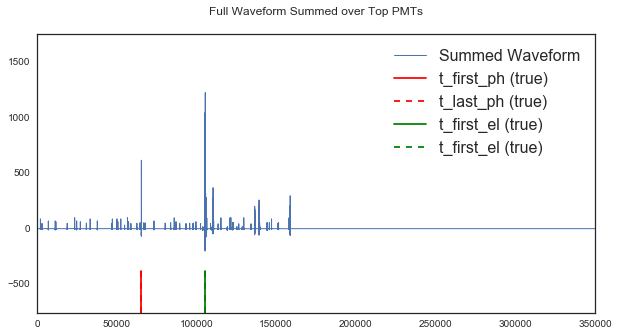

In [152]:

####################################################################################################
# Plot Full Summed Waveform
####################################################################################################

f = plt.figure(figsize=[10, 5])
plt.plot(df_sum, label="Summed Waveform", linewidth=1)
plt.title("Full Waveform Summed over Top PMTs", y=1.05)
plt.axvline(x=samp0_s1, ymax=0.15, color='r', linestyle='solid' , label='t_first_ph (true)')
plt.axvline(x=samp1_s1, ymax=0.15, color='r', linestyle='dashed', label='t_last_ph (true)')
plt.axvline(x=samp0_s2, ymax=0.15, color='g', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s2, ymax=0.15, color='g', linestyle='dashed', label='t_first_el (true)')
y0, y1 = plt.ylim()
dy     = y1 - y0
y0     = y0 - 0.2*dy
y1     = y1 + 0.2*dy
plt.ylim([y0, y1])
leg = plt.legend(fontsize=16)

plt.close()

print()
display(f)
print()



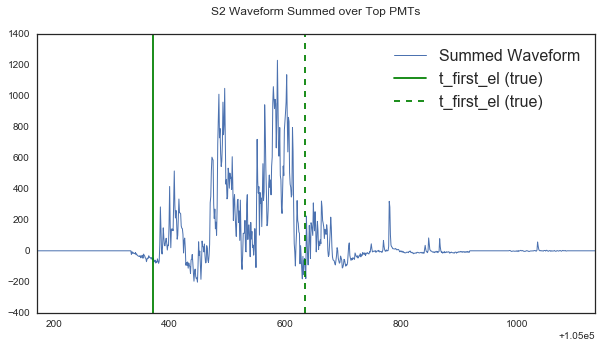

In [153]:

####################################################################################################
# Plot S2 Summed Waveform
####################################################################################################

f = plt.figure(figsize=[10, 5])
plt.plot(df_sum, label="Summed Waveform", linewidth=1)
plt.title("S2 Waveform Summed over Top PMTs", y=1.05)
plt.axvline(x=samp0_s2, color='g', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s2, color='g', linestyle='dashed', label='t_first_el (true)')
plt.xlim([samp0_s2 - 200, samp1_s2 + 500])

leg = plt.legend(fontsize=16)

plt.close()

print()
display(f)
print()


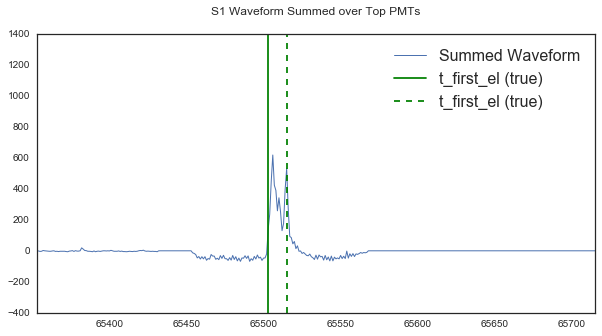

In [154]:

####################################################################################################
# Plot S1 Summed Waveform
####################################################################################################

f = plt.figure(figsize=[10, 5])
plt.plot(df_sum, label="Summed Waveform", linewidth=1)
plt.title("S1 Waveform Summed over Top PMTs", y=1.05)
plt.axvline(x=samp0_s1, color='g', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s1, color='g', linestyle='dashed', label='t_first_el (true)')
#y0, y1 = plt.ylim()
#dy     = y1 - y0
#y0     = y0 - 0.2*dy
#y1     = y1 + 0.2*dy
#plt.ylim([y0, y1])
plt.xlim([samp0_s1 - 150, samp1_s1 + 200])

leg = plt.legend(fontsize=16)

plt.close()

print()
display(f)
print()



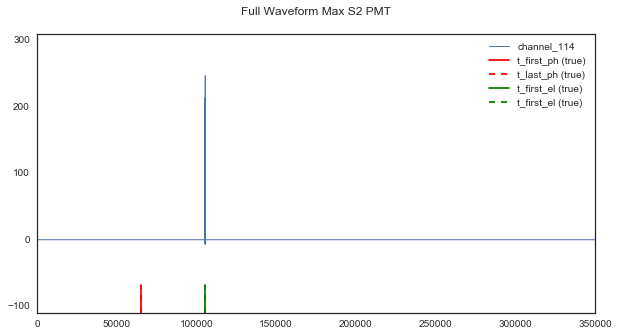

In [155]:

####################################################################################################
# Plot Max PMT Full Waveform
####################################################################################################

f = plt.figure(figsize=[10, 5])
plt.plot(arr_waveform_rank001, linewidth=1)
t1 = plt.title("Full Waveform Max S2 PMT", y=1.05)
plt.axvline(x=samp0_s1, ymax=0.1, color='r', linestyle='solid' , label='t_first_ph (true)')
plt.axvline(x=samp1_s1, ymax=0.1, color='r', linestyle='dashed', label='t_last_ph (true)')
plt.axvline(x=samp0_s2, ymax=0.1, color='g', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s2, ymax=0.1, color='g', linestyle='dashed', label='t_first_el (true)')
y0, y1 = plt.ylim()
dy     = y1 - y0
y0     = y0 - 0.2*dy
y1     = y1 + 0.2*dy
plt.ylim([y0, y1])
leg = plt.legend()

f.savefig("plots/s2_waveform_pmt_maxS2.png")
plt.close()

print()
display(f)
print()



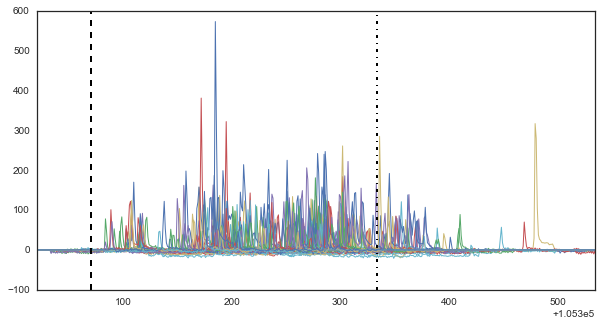

In [255]:


####################################################################################################
# Superimpose PMT Waveforms
####################################################################################################

f = plt.figure(figsize=[10, 5])

df_pmts = wfs.get_waveforms_in_channels(nEvent)
df_pmts = df_pmts.iloc[:, 0:127]

for i in range(0 , 127):
    
    df = df_pmts.iloc[:, i:i+1]
    
    plt.plot(df, linewidth=1)
    plt.axvline(x=samp0_s2, color='k', linestyle='dashed' , label='t_first_el (true)')
    plt.axvline(x=samp1_s2, color='k', linestyle='dashdot', label='t_last_el  (true)')
    plt.xlim([samp0_s2 - 50, samp1_s2 + 200])
    

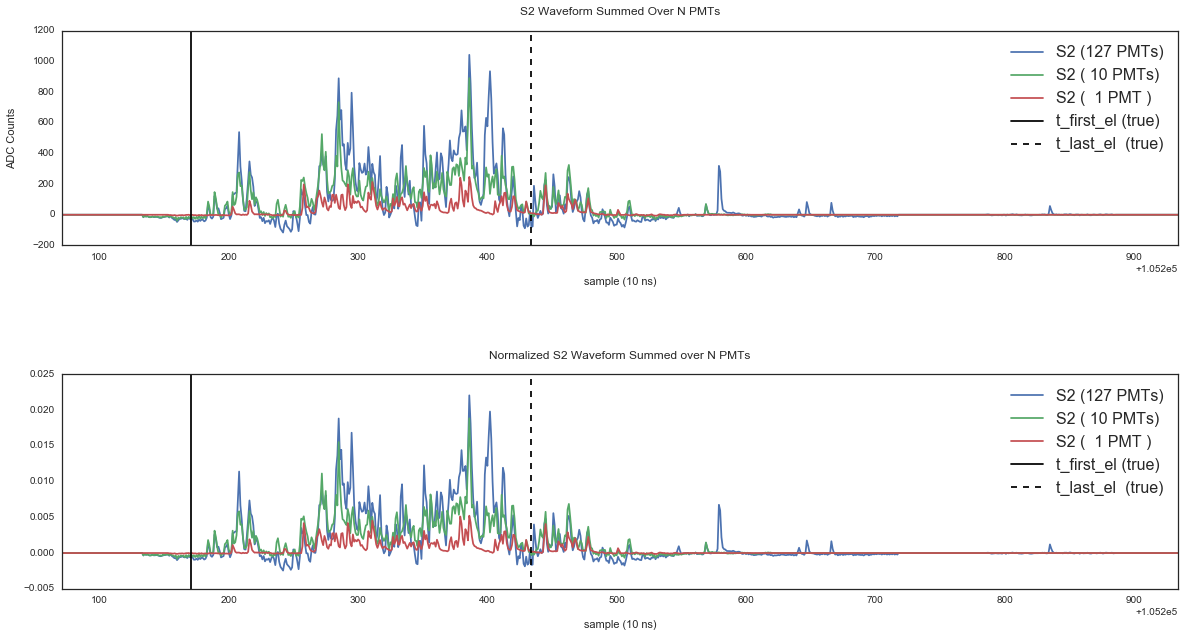

In [257]:

####################################################################################################
####################################################################################################

f = plt.figure(figsize=[20, 20])
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.6)

ax1 = plt.subplot(2, 1, 1)
plt.plot(arr_waveform_sum127, label='S2 (127 PMTs)')
plt.title('S2 Waveform Summed Over N PMTs', y=1.05)
plt.plot(arr_waveform_sum010, label='S2 ( 10 PMTs)')
plt.plot(arr_waveform_sum001, label='S2 (  1 PMT )')
plt.axvline(x=samp0_s2, color='k', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s2, color='k', linestyle='dashed', label='t_last_el  (true)')
plt.xlabel('sample (10 ns)')
plt.ylabel('ADC Counts')
plt.xlim([samp0_s2-100, samp1_s2+500])
plt.legend(fontsize=16)

#
ax2 = plt.subplot(2, 1, 2)
plt.plot(arr_waveform_sum127_norm, label='S2 (127 PMTs)')
plt.plot(arr_waveform_sum010_norm, label='S2 ( 10 PMTs)')
plt.plot(arr_waveform_sum001_norm, label='S2 (  1 PMT )')
plt.axvline(x=samp0_s2, color='k', linestyle='solid' , label='t_first_el (true)')
plt.axvline(x=samp1_s2, color='k', linestyle='dashed', label='t_last_el  (true)')
plt.title('Normalized S2 Waveform Summed over N PMTs', y=1.05)
plt.xlabel('sample (10 ns)')
plt.xlim([samp0_s2-100, samp1_s2+500])
plt.legend(fontsize=16)

f.savefig("plots/s2_summed_waveforms.png")
plt.close()

print()
display(f)
print()



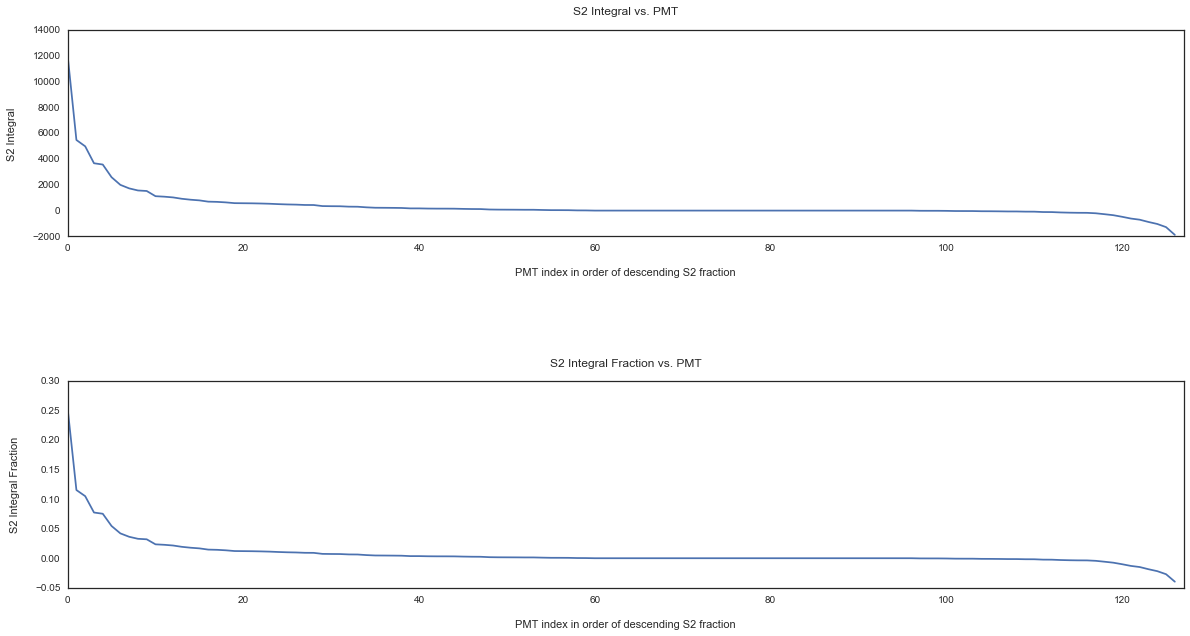

In [158]:


####################################################################################################
####################################################################################################

##########################################################################################
# Plot the S2 contribution per PMT
##########################################################################################

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.7)

ax1 = plt.subplot(2, 1, 1)
plt.plot(arr_s2sum_ranked)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral')
plt.title('S2 Integral vs. PMT', y=1.05)

ax2 = plt.subplot(2, 1, 2)
plt.plot(arr_s2frac_ranked)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral Fraction')
plt.title('S2 Integral Fraction vs. PMT', y=1.05)

f.savefig("plots/s2_integral_vs_pmt.png")
plt.close()

print()
display(f)
print()


1315

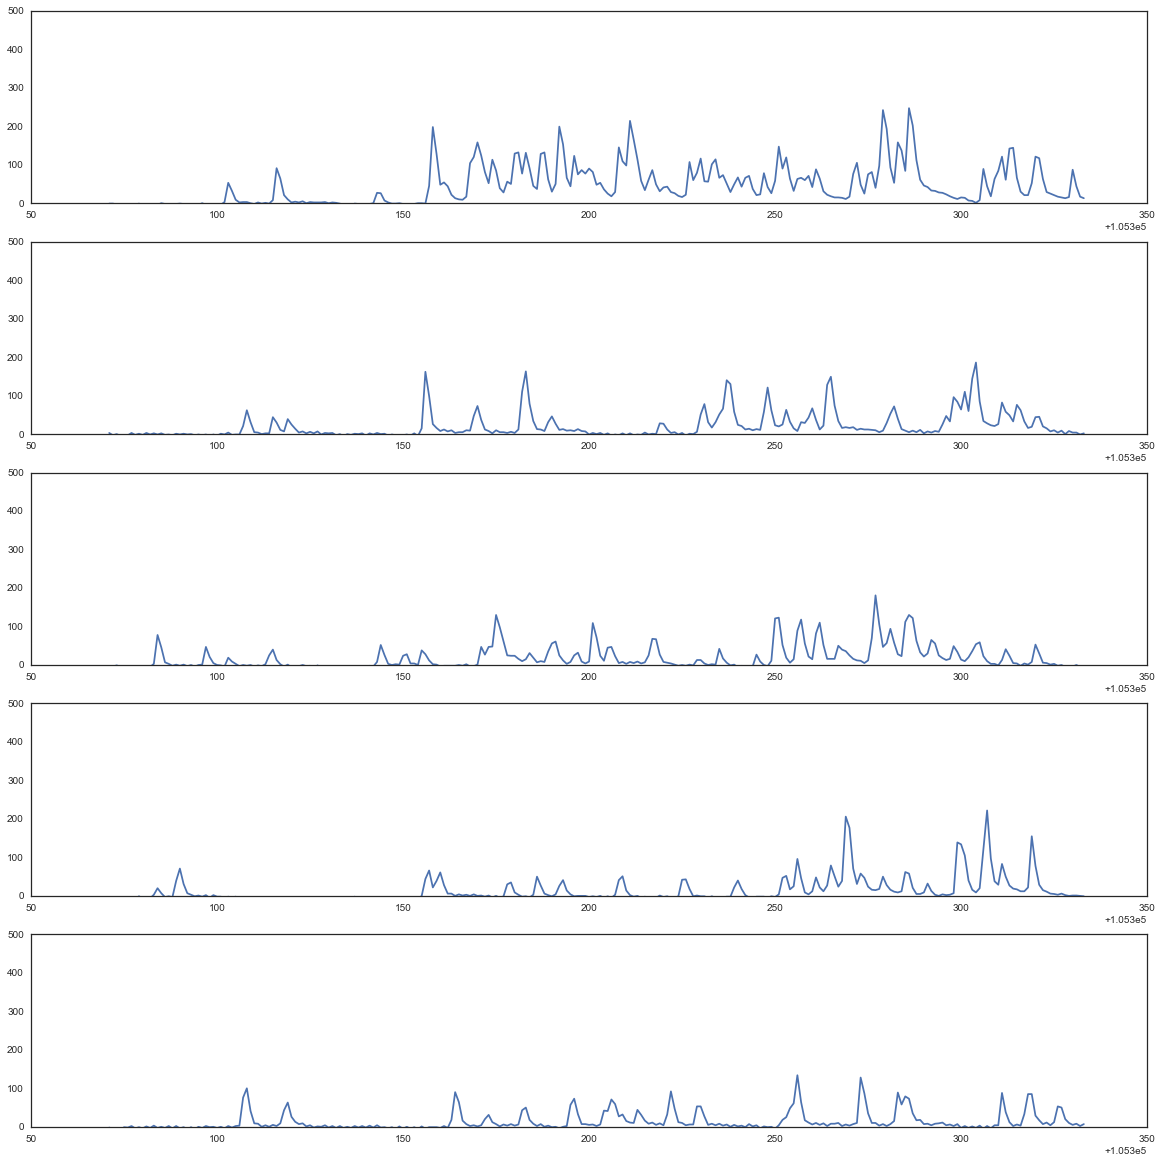

In [254]:

####################################################################################################
####################################################################################################

lst = list()

lst.append(arr_waveform_rank001[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank002[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank003[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank004[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank005[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank006[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank007[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank008[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank009[samp0_s2:samp1_s2])
lst.append(arr_waveform_rank010[samp0_s2:samp1_s2])


nPlots = 5

f, ax = plt.subplots(nrows=nPlots, ncols=1, figsize=(20, 20))

for i in range(0, nPlots):
    
    ax = plt.subplot(nPlots, 1, i+1)

    plt.plot(lst[i])
    plt.ylim([0, 500])
    continue
    
    
#plt.plot(arr_waveform_sum127, label='S2 (127 PMTs)')
#plt.title('S2 Waveform Summed Over N PMTs', y=1.05)
#plt.plot(arr_waveform_sum010, label='S2 ( 10 PMTs)')
#plt.plot(arr_waveform_sum001, label='S2 (  1 PMT )')
#plt.axvline(x=samp0_s2, color='k', linestyle='solid' , label='t_first_el (true)')
#plt.axvline(x=samp1_s2, color='k', linestyle='dashed', label='t_last_el  (true)')
#plt.xlabel('sample (10 ns)')
#plt.ylabel('ADC Counts')
#plt.xlim([samp0_s2-100, samp1_s2+500])
#plt.legend(fontsize=16)



In [ ]:

####################################################################################################
####################################################################################################

a1 = arr_waveform_rank001[samp0_s2:samp1_s2]
a2 = arr_waveform_rank002[samp0_s2:samp1_s2]
a3 = arr_waveform_rank003[samp0_s2:samp1_s2]
a4 = arr_waveform_rank004[samp0_s2:samp1_s2]
a5 = arr_waveform_rank005[samp0_s2:samp1_s2]
a6 = arr_waveform_rank006[samp0_s2:samp1_s2]
a7 = arr_waveform_rank007[samp0_s2:samp1_s2]
a8 = arr_waveform_rank008[samp0_s2:samp1_s2]
a9 = arr_waveform_rank009[samp0_s2:samp1_s2]
a10 = arr_waveform_rank010[samp0_s2:samp1_s2]


nPlots   = 5
nSamples = a1.size


a = np.zeros(0)
a = np.append(a, a1)
a = np.append(a, a2)
a = np.append(a, a3)
a = np.append(a, a4)
a = np.append(a, a5)
#a = np.append(a, a6)
#a = np.append(a, a7)
#a = np.append(a, a8)
#a = np.append(a, a9)
#a = np.append(a, a10)

#alist = np.tile(list("ABCDEFGHIJ"), nSamples)
alist = np.tile(list("ABCDE"), nSamples)


a.size

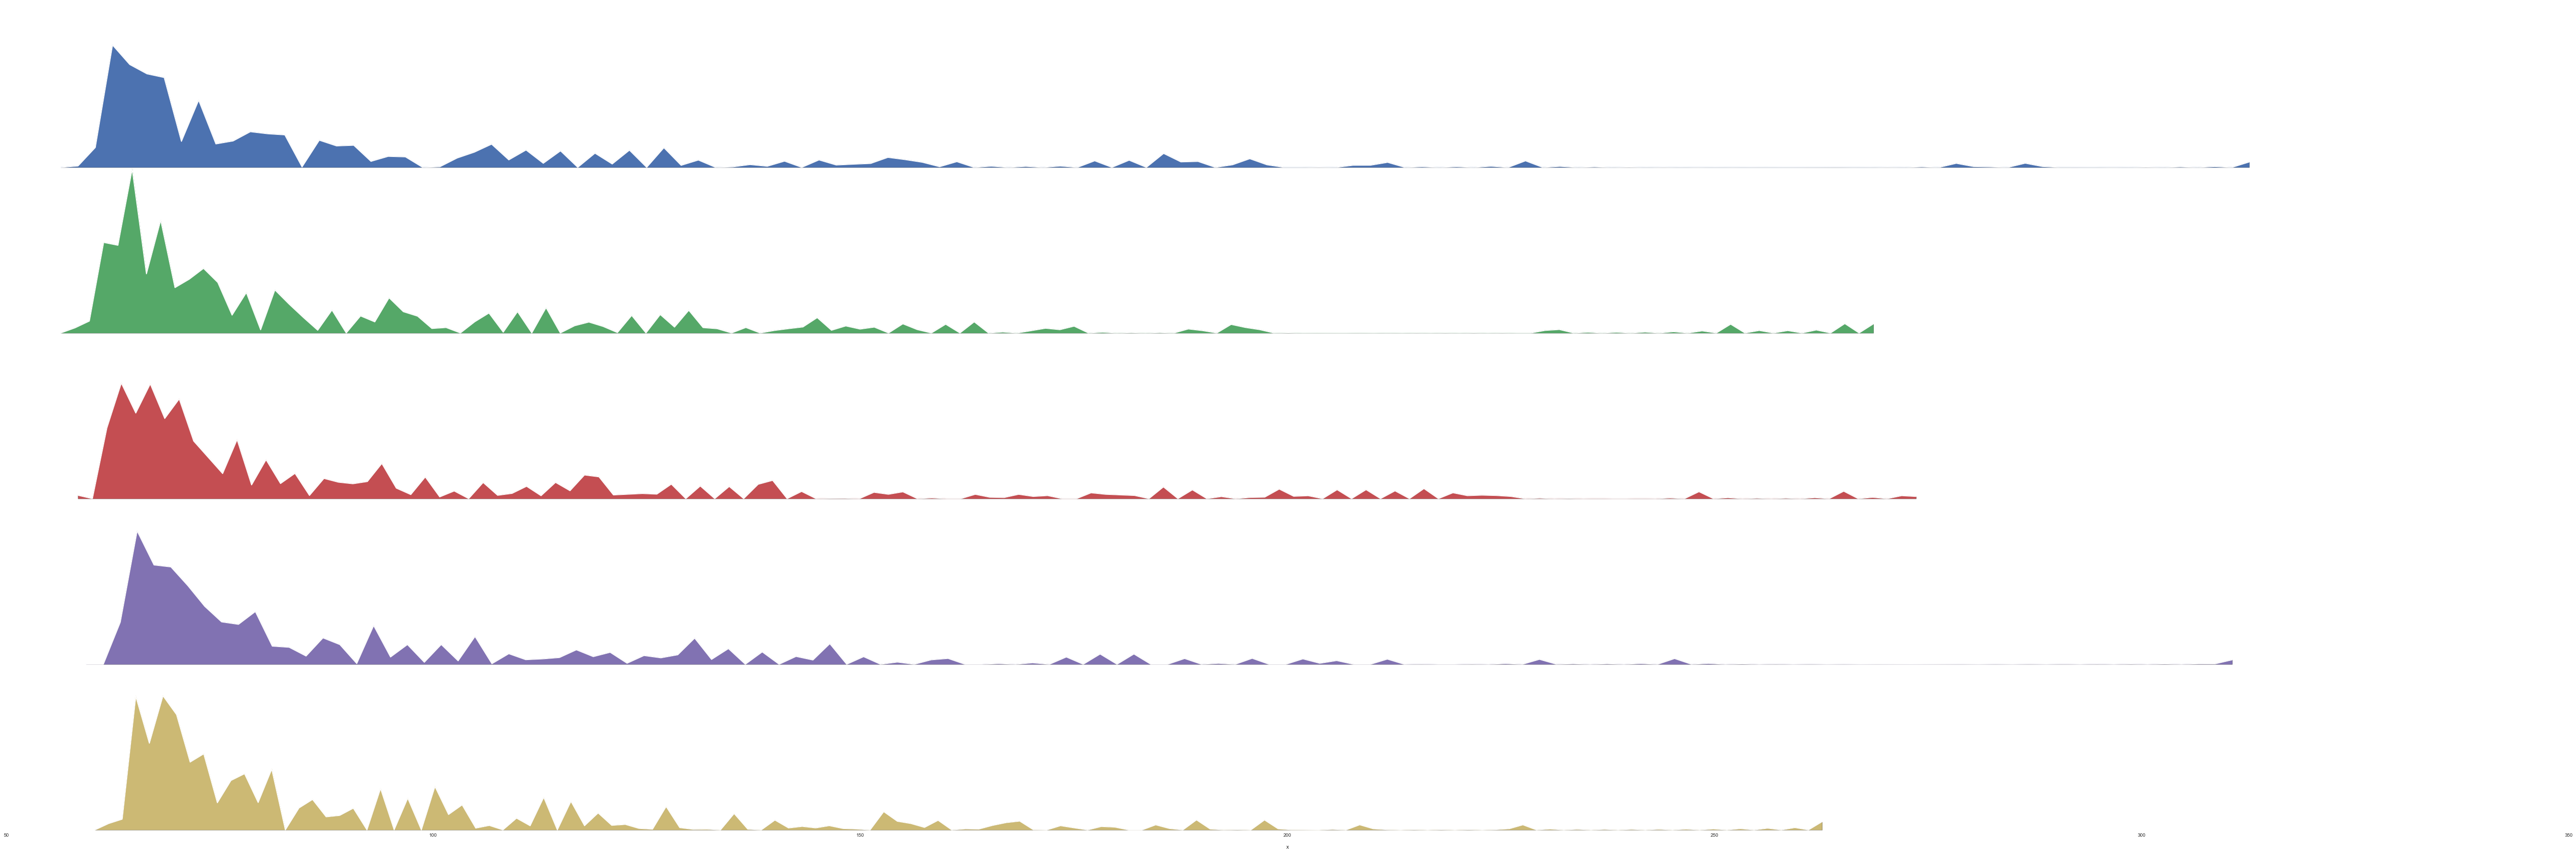

In [244]:

####################################################################################################
####################################################################################################

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


####################################################################################################\
# Create the data
####################################################################################################

#nSamples = 50
#nPlots   = 10

#rs = np.random.RandomState(1979)
#x = rs.randn(nSamples*nPlots)
#arr_g = np.tile(list("ABCDEFGHIJ"), nSamples)

#df    = pd.DataFrame(dict(x=x, g=arr_g))
df    = pd.DataFrame(dict(x=a, g=alist))

m = df.g.map(ord)
df["x"] += m


####################################################################################################
# Initialize the FacetGrid object
####################################################################################################

pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
#g   = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5)
g   = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=5)


####################################################################################################
# Draw the densities in a few steps
####################################################################################################

g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)


####################################################################################################
# Style
####################################################################################################

#g.map(plt.axhline, y=0, lw=2, clip_on=False)

#
#####################################################################################################
## Define and use a simple function to label the plot in axes coordinates
#####################################################################################################
#
#def label(x, color, label):
#    ax = plt.gca()
#    #ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)
#
#g.map(label, "x")
#

####################################################################################################
# Set the subplots to overlap
####################################################################################################

g.fig.subplots_adjust(hspace=.01)



#####################################################################################################
## Remove axes details that don't play will with overlap
#####################################################################################################

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)


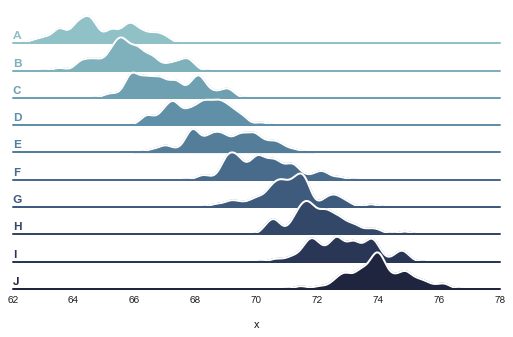

In [159]:

##########################################################################################
# Facet Grid
##########################################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

<class 'numpy.ndarray'>


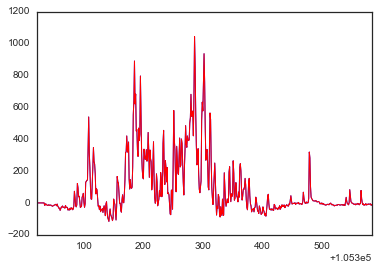

In [176]:

##########################################################################################
# Sanity
##########################################################################################

sum_waveforms = wfs.waveforms_in_channels[nEvent].drop("event_number", axis=1).iloc[:, 0:127].sum(axis=1).as_matrix()
sum_s2_all    = np.sum(sum_waveforms)

plt.plot(sum_waveforms      , color='b', linewidth=1)
plt.plot(arr_waveform_sum127, color='r', linewidth=1)
plt.xlim([samp0_s2-50, samp1_s2+250])

eq = np.equal(sum_waveforms,arr_waveform_sum127)

print(type(eq))

if (np.count_nonzero(eq) != eq.size):
    
    print("Error!")



In [ ]:

##########################################################################################
# Debug Uncorrected Waveforms
##########################################################################################

#df_pmts = wfs.get_waveforms_in_channels(nEvent)
#df      = df_pmts.iloc[:, 0:1].copy(deep=True)
#    
#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
#
##
#plt.subplot(2, 2, 1)
#ax1 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t1 = plt.title("Single PMT Waveform", y=1.05)
#
##
#df.replace(0.0, 16000, inplace=True)
#df -= 16000
#
#plt.subplot(2, 2, 2)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t2 = plt.title("Single PMT Waveform, Pedestal Subtracted (16000 ADC)", y=1.05)
#
##
#df *= -1

#plt.subplot(2, 2, 3)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0-50, s1+200])
#t3 = plt.title("Single PMT Waveform, Inverted, Pedestal Subtracted", y=1.05)
#
##
#plt.subplot(2, 2, 4)
#ax2 = plt.plot(df, linewidth=1)
#plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_el (true)')
#plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_el  (true)')
#plt.xlim([s0+75, s1-10])
#plt.ylim([-20, 60])
#t4 = plt.title("Single PMT Waveform Corrected Zoom", y=1.05)

#fig.savefig("plots/s2_single_pmt_waveform_bug.png")